# Slurry Composition Optimization with Bayesian Optimization

**Objective**: Optimize slurry composition (5 components summing to 100%) to achieve optimal measurement parameters.

## 🔄 Real-World Workflow (Single CSV File)

1. **Generate Batch** → Adds 5 new rows to CSV
2. **Lab Work** → Fill in M1, M2, M3, M4 for new rows
3. **Load Results** → Import measurements back into notebook
4. **Optimize** → Bayesian optimization suggests next batch
5. **Repeat** → Adds another 5 rows to SAME CSV

## 📁 File Structure

- `optimization_data/` - Folder with optimization data
  - `all_batches.csv` - **ONE file** with all batches
    - Rows 1-5: Initial random batch (Iteration 0)
    - Rows 6-10: First optimized batch (Iteration 1)
    - Rows 11-15: Second optimized batch (Iteration 2)
    - etc.

## 🎯 Key Features

- **Single CSV file**: All batches in one place - easy to track
- **Iterative workflow**: Each batch adds 5 rows to the same file
- **Flexible**: Pause anytime, resume later
- **5 components**: C1, C2, C3, C4 (optimized) + C5 (calculated to sum to 100%)
- **4 measurements**: M1, M2, M3, M4 (customize for your parameters)

**Requirements**: `pip install torch botorch gpytorch matplotlib pandas numpy`

## 1. Import Required Libraries

In [19]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# BoTorch and GPyTorch imports
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, qLogNoisyExpectedImprovement
from botorch.acquisition.analytic import PosteriorStandardDeviation
from botorch.optim import optimize_acqf
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood

# Set up device and data type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print(f"BoTorch version: {botorch.__version__}")
print("Libraries loaded successfully!")

Device: cpu
BoTorch version: 0.16.0
Libraries loaded successfully!


## 2. Define Problem Parameters and Constraints

Set up the slurry composition bounds and measurement parameter targets.

In [20]:
# ===== PLACEHOLDER VARIABLES - CUSTOMIZE FOR YOUR APPLICATION =====

# Component names and bounds (PLACEHOLDERS - change to your components)
COMPONENT_NAMES = ['C1', 'C2', 'C3', 'C4', 'C5']
COMPONENT_BOUNDS = {
    'C1': (0.2, 1.5),   # CMC: 0.2-1.5%
    'C2': (0, 20),      # PEG: 2-20%
    'C3': (0, 11),      # Glycerol: 0-11%
    'C4': (2, 30),     # Water: 2-30%
    'C5': (55, 80)      # BaTiO3: 55-80% (= 100 - C1 - C2 - C3 - C4)
}

# Measurement parameter names and optimal ranges (PLACEHOLDERS)
PARAMETER_NAMES = ['M1', 'M2', 'M3', 'M4']
PARAMETER_UNITS = ['units1', 'units2', 'units3', 'units4']
OPTIMAL_RANGES = {
    'M1': (25, 10000),    # Geq
    'M2': (100, 2000),     # tau f
    'M3': (100, 800),    # tau y
    'M4': (100, 1000),    # Viscosity 
}


# Penalty weights for being outside optimal ranges
PENALTY_WEIGHTS = {'M1': 1.0, 'M2': 1.0, 'M3': 1.0, 'M4': 1.0}

# Measurement variances from repeated experiments (std² from n=5 repetitions)
# M1: std=0.1, M2: std=0.0004, M3: std=0.1, M4: std=0.1
MEASUREMENT_VARIANCES = {'M1': 0.01, 'M2': 1.6e-7, 'M3': 0.01, 'M4': 0.01}

# Convert to BoTorch format (optimize first 4 components, calculate C5)
bounds_tensor = torch.tensor([
    [COMPONENT_BOUNDS[name][0] for name in COMPONENT_NAMES[:-1]],  # Lower bounds
    [COMPONENT_BOUNDS[name][1] for name in COMPONENT_NAMES[:-1]]   # Upper bounds
], dtype=dtype, device=device)

print("Component Bounds:")
for i, name in enumerate(COMPONENT_NAMES):
    bounds = COMPONENT_BOUNDS[name]
    calc_note = "(calculated)" if i == 4 else "(optimized)"
    print(f"  {name}: {bounds[0]}-{bounds[1]}% {calc_note}")

print(f"\nParameter Targets:")
for param in PARAMETER_NAMES:
    low, high = OPTIMAL_RANGES[param]
    weight = PENALTY_WEIGHTS[param]
    print(f"  {param}: {low}-{high} (penalty weight: {weight})")

def compositions_from_reduced(x_reduced):
    """Convert 4D optimization variables to full 5D composition"""
    if x_reduced.dim() == 1:
        x_reduced = x_reduced.unsqueeze(0)
    
    # Calculate C5 = 100% - sum(C1,C2,C3,C4)
    c5 = 100.0 - x_reduced.sum(dim=1, keepdim=True)
    full_compositions = torch.cat([x_reduced, c5], dim=1)
    return full_compositions

def check_feasibility(x_reduced):
    """
    Check if composition satisfies all constraints:
    1. All components C1-C4 are non-negative
    2. C5 is non-negative  
    3. C5 is within its bounds
    4. Sum of all components equals 100%
    """
    # Check non-negativity of C1-C4
    if (x_reduced < 0).any():
        return False
    
    # Calculate full composition
    compositions = compositions_from_reduced(x_reduced)
    c5 = compositions[:, -1]
    
    # Check non-negativity of C5
    if (c5 < 0).any():
        return False
    
    # Check C5 bounds
    c5_bounds = COMPONENT_BOUNDS['C5']
    feasible = (c5 >= c5_bounds[0]) & (c5 <= c5_bounds[1])
    
    # Verify sum equals 100% (with small tolerance for numerical precision)
    total_sum = compositions.sum(dim=1)
    feasible = feasible & (torch.abs(total_sum - 100.0) < 1e-6)
    
    # Additional validation: check if bounds allow feasible solutions
    if not feasible.all():
        # Calculate bounds consistency
        max_sum_C1_to_C4 = sum(COMPONENT_BOUNDS[f'C{i}'][1] for i in range(1, 5))
        min_sum_C1_to_C4 = sum(COMPONENT_BOUNDS[f'C{i}'][0] for i in range(1, 5))
        
        if max_sum_C1_to_C4 + c5_bounds[0] > 100.0:
            remaining = 100.0 - c5_bounds[0]
            print(f"⚠️ WARNING: Upper bounds too high! Max(C1+C2+C3+C4) = {max_sum_C1_to_C4}% leaves {remaining - max_sum_C1_to_C4}% for C5")
            print(f"   Suggestion: Ensure max(C1+C2+C3+C4) ≤ {100.0 - c5_bounds[0]}% to respect C5_min = {c5_bounds[0]}%")
        
        if min_sum_C1_to_C4 + c5_bounds[1] < 100.0:
            remaining = 100.0 - c5_bounds[1]
            print(f"⚠️ WARNING: Lower bounds too low! Min(C1+C2+C3+C4) = {min_sum_C1_to_C4}% leaves {100.0 - min_sum_C1_to_C4}% for C5")
            print(f"   Suggestion: Ensure min(C1+C2+C3+C4) ≥ {100.0 - c5_bounds[1]}% to respect C5_max = {c5_bounds[1]}%")
    
    return feasible.all()



# Test feasibility function
test_comp = torch.tensor([[25, 20, 30, 10]], dtype=dtype, device=device)
test_full = compositions_from_reduced(test_comp)
print(f"\nTest: {test_comp.squeeze().cpu().numpy()} -> {test_full.squeeze().cpu().numpy()}")
print(f"Sum: {test_full.sum():.1f}%, Feasible: {check_feasibility(test_comp)}")

Component Bounds:
  C1: 0.2-1.5% (optimized)
  C2: 0-20% (optimized)
  C3: 0-11% (optimized)
  C4: 2-30% (optimized)
  C5: 55-80% (calculated)

Parameter Targets:
  M1: 25-10000 (penalty weight: 1.0)
  M2: 100-2000 (penalty weight: 1.0)
  M3: 100-800 (penalty weight: 1.0)
  M4: 100-1000 (penalty weight: 1.0)

Test: [25. 20. 30. 10.] -> [25. 20. 30. 10. 15.]
⚠️ WARNING: Upper bounds too high! Max(C1+C2+C3+C4) = 62.5% leaves -17.5% for C5
   Suggestion: Ensure max(C1+C2+C3+C4) ≤ 45.0% to respect C5_min = 55%
⚠️ WARNING: Lower bounds too low! Min(C1+C2+C3+C4) = 2.2% leaves 97.8% for C5
   Suggestion: Ensure min(C1+C2+C3+C4) ≥ 20.0% to respect C5_max = 80%
Sum: 100.0%, Feasible: False


## for reducing uncertentay while mean is 0.


In [12]:
# for reducing uncertentay while mean is 0.


def feasibility_mask(x_reduced: torch.Tensor) -> torch.Tensor:
    """
    x_reduced: (N, d) tensor in reduced / normalized space.
    Returns:   (N,) bool tensor indicating feasibility for each row.
    """
    # Non-negativity of C1–C4 (assuming x_reduced encodes these or related vars)
    if (x_reduced < 0).any():
        # Any negative → that row is infeasible
        # We'll mark via mask, so no early return here
        pass

    compositions = compositions_from_reduced(x_reduced)  # (N, 5) say
    c5 = compositions[:, -1]

    # Base mask: all true, then progressively AND constraints
    mask = torch.ones(x_reduced.shape[0], dtype=torch.bool, device=x_reduced.device)

    # Non-negativity of C1–C4 and C5
    mask &= (x_reduced >= 0).all(dim=1)
    mask &= c5 >= 0

    # C5 bounds
    c5_min, c5_max = COMPONENT_BOUNDS["C5"]
    mask &= (c5 >= c5_min) & (c5 <= c5_max)

    # Sum equals 100% (within tolerance)
    total_sum = compositions.sum(dim=1)
    mask &= torch.abs(total_sum - 100.0) < 1e-6

    return mask


def check_bounds_consistency():
    """
    Optional one-off check to see if the COMPONENT_BOUNDS are even compatible.
    Call this once when setting up the problem, not per point.
    """
    c5_bounds = COMPONENT_BOUNDS["C5"]
    c5_min, c5_max = c5_bounds

    max_sum_C1_to_C4 = sum(COMPONENT_BOUNDS[f"C{i}"][1] for i in range(1, 5))
    min_sum_C1_to_C4 = sum(COMPONENT_BOUNDS[f"C{i}"][0] for i in range(1, 5))

    if max_sum_C1_to_C4 + c5_min > 100.0:
        remaining = 100.0 - c5_min
        print(
            f"⚠️ WARNING: Upper bounds too high! Max(C1+C2+C3+C4) = {max_sum_C1_to_C4}% "
            f"leaves {remaining - max_sum_C1_to_C4}% for C5"
        )
        print(
            f"   Suggestion: Ensure max(C1+C2+C3+C4) ≤ {100.0 - c5_min}% to respect C5_min = {c5_min}%"
        )

    if min_sum_C1_to_C4 + c5_max < 100.0:
        remaining = 100.0 - c5_max
        print(
            f"⚠️ WARNING: Lower bounds too low! Min(C1+C2+C3+C4) = {min_sum_C1_to_C4}% "
            f"leaves {100.0 - min_sum_C1_to_C4}% for C5"
        )
        print(
            f"   Suggestion: Ensure min(C1+C2+C3+C4) ≥ {100.0 - c5_max}% to respect C5_max = {c5_max}%"
        )


def check_feasibility(x_reduced: torch.Tensor) -> bool:
    """
    Returns True only if *all* rows in x_reduced are feasible.
    """
    mask = feasibility_mask(x_reduced)
    return bool(mask.all())

## 3. Helper Functions for CSV-based Measurement Workflow

**Real-world workflow**: Export compositions → Measure in lab → Import results → Generate next batch

In [21]:
import os
from datetime import datetime

# Create data directory and main CSV file
DATA_DIR = "optimization_data"
os.makedirs(DATA_DIR, exist_ok=True)
MAIN_CSV = os.path.join(DATA_DIR, "all_batches.csv")

def add_compositions_to_csv(compositions, iteration):
    """
    Add new compositions to the main CSV file (appends to existing data).
    
    Args:
        compositions: torch.tensor of shape (n, 5) with full compositions
        iteration: int, current iteration number (0 for initial batch)
    
    Returns:
        tuple: (filepath, start_idx, end_idx) - indices of new samples in file
    """
    # Convert to DataFrame
    new_df = pd.DataFrame(
        compositions.cpu().numpy(),
        columns=COMPONENT_NAMES
    )
    
    # Add iteration and empty measurement columns
    new_df.insert(0, 'Iteration', iteration)
    for param in PARAMETER_NAMES:
        new_df[param] = np.nan
    
    # Load existing data or create new
    if os.path.exists(MAIN_CSV):
        existing_df = pd.read_csv(MAIN_CSV)
        start_idx = len(existing_df) + 1
        new_df.insert(0, 'Sample_ID', range(start_idx, start_idx + len(new_df)))
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        start_idx = 1
        new_df.insert(0, 'Sample_ID', range(start_idx, start_idx + len(new_df)))
        combined_df = new_df
    
    end_idx = start_idx + len(new_df) - 1
    
    # Save
    combined_df.to_csv(MAIN_CSV, index=False)
    
    print(f"✓ Added {len(new_df)} compositions to: {MAIN_CSV}")
    print(f"✓ New samples: #{start_idx} to #{end_idx}")
    print(f"✓ Total samples in file: {len(combined_df)}")
    print(f"\nNext steps:")
    print(f"1. Open: {MAIN_CSV}")
    print(f"2. Fill in M1, M2, M3, M4 for samples #{start_idx}-#{end_idx}")
    print(f"3. Save and run next cell to load measurements")
    
    return MAIN_CSV, start_idx, end_idx


def load_new_measurements(start_idx=None, end_idx=None, iteration=None):
    """
    Load only the newly measured samples from the main CSV.

    Accepts either an `iteration` number (preferred) or a `start_idx`/`end_idx` range.

    Args:
        start_idx: first sample index to load (fallback)
        end_idx: last sample index to load (fallback)
        iteration: integer iteration number to load all rows with that iteration

    Returns:
        tuple: (compositions_tensor, measurements_tensor, sample_ids)
    """
    if not os.path.exists(MAIN_CSV):
        raise FileNotFoundError(f"File not found: {MAIN_CSV}")

    df = pd.read_csv(MAIN_CSV)

    # Prefer iteration-based selection when provided
    if iteration is not None:
        new_samples = df[df['Iteration'] == iteration]
        if len(new_samples) == 0:
            raise ValueError(f"No samples found for iteration {iteration} in {MAIN_CSV}")
        selection_note = f"iteration {iteration} (rows #{int(new_samples['Sample_ID'].min())} to #{int(new_samples['Sample_ID'].max())})"
    else:
        if start_idx is None or end_idx is None:
            raise ValueError("Provide either `iteration` or both `start_idx` and `end_idx` to load samples")
        # Filter to new samples by Sample_ID range
        new_samples = df[(df['Sample_ID'] >= start_idx) & (df['Sample_ID'] <= end_idx)]
        if len(new_samples) == 0:
            raise ValueError(f"No samples found between #{start_idx} and #{end_idx}")
        selection_note = f"samples #{start_idx} to #{end_idx}"

    # Check if measurements are filled in
    missing = new_samples[PARAMETER_NAMES].isna().any().any()
    if missing:
        missing_rows = new_samples[new_samples[PARAMETER_NAMES].isna().any(axis=1)]['Sample_ID'].tolist()
        raise ValueError(
            f"Measurements incomplete for samples: {missing_rows}\n"
            f"Please fill in all M1, M2, M3, M4 values in {MAIN_CSV}"
        )

    # Extract compositions
    compositions = torch.tensor(
        new_samples[COMPONENT_NAMES].values,
        dtype=dtype,
        device=device
    )

    # Extract measurements
    measurements = torch.tensor(
        new_samples[PARAMETER_NAMES].values,
        dtype=dtype,
        device=device
    )

    sample_ids = new_samples['Sample_ID'].tolist()

    print(f"✓ Loaded measurements for {selection_note}")
    print(f"  - Number of samples: {len(new_samples)}")
    print(f"\nMeasurement summary:")
    print(new_samples[PARAMETER_NAMES].describe().round(2))

    return compositions, measurements, sample_ids


def load_all_data():
    """
    Load all completed measurements from the main CSV.
    
    Returns:
        tuple: (compositions_tensor, measurements_tensor, sample_ids)
    """
    if not os.path.exists(MAIN_CSV):
        raise FileNotFoundError(f"File not found: {MAIN_CSV}")

    df = pd.read_csv(MAIN_CSV)

    # Filter to only rows with complete measurements
    complete_mask = ~df[PARAMETER_NAMES].isna().any(axis=1)
    complete_df = df[complete_mask]

    if len(complete_df) == 0:
        raise ValueError(f"No complete measurements found in {MAIN_CSV}")

    compositions = torch.tensor(
        complete_df[COMPONENT_NAMES].values,
        dtype=dtype,
        device=device
    )

    measurements = torch.tensor(
        complete_df[PARAMETER_NAMES].values,
        dtype=dtype,
        device=device
    )

    sample_ids = complete_df['Sample_ID'].tolist()

    print(f"✓ Loaded {len(complete_df)} complete measurements from {MAIN_CSV}")

    return compositions, measurements, sample_ids


def calculate_penalty(measurements):
    """
    Calculate total penalty for measurements outside optimal ranges.
    
    Returns:
        tuple: (penalties, penalty_variances)
            - penalties: torch.tensor of shape (n_samples,)
            - penalty_variances: torch.tensor of shape (n_samples,)
    """
    n_samples = measurements.shape[0]
    total_penalty = torch.zeros(n_samples, dtype=dtype, device=device)
    total_variance = torch.zeros(n_samples, dtype=dtype, device=device)

    for i, param in enumerate(PARAMETER_NAMES):
        values = measurements[:, i]
        low, high = OPTIMAL_RANGES[param]
        weight = PENALTY_WEIGHTS[param]
        variance = MEASUREMENT_VARIANCES[param]

        # Penalty = 0 inside range, linear outside
        below_range = torch.clamp(low - values, min=0)
        above_range = torch.clamp(values - high, min=0)
        penalty = weight * (below_range + above_range)
        # print(f"({low} ,{high}) - {int(penalty)}")
        total_penalty += penalty

        # Variance propagation for linear penalty: Var(w*x) = w²*Var(x)
        measurement_variance = (weight*variance)**2
        total_variance += variance

    return total_penalty, total_variance


def display_batch_results(compositions, measurements, iteration, sample_ids=None):
    """Display results for a batch"""
    penalties = calculate_penalty(measurements)
    
    print(f"\n{'='*60}")
    print(f"BATCH {iteration} RESULTS")
    print(f"{'='*60}")
    
    # Combine data
    df = pd.DataFrame(
        compositions.cpu().numpy(),
        columns=COMPONENT_NAMES
    )
    
    if sample_ids is not None:
        df.insert(0, 'Sample_ID', sample_ids)
    else:
        df.insert(0, 'Sample_ID', range(1, len(df) + 1))
    
    for i, param in enumerate(PARAMETER_NAMES):
        df[param] = measurements[:, i].cpu().numpy()
    
    df['Penalty'] = penalties[0].cpu().numpy()
    
    print(df.round(2))
    
    # Find best sample
    best_idx = penalties[0].argmin()
    best_id = sample_ids[best_idx] if sample_ids else best_idx + 1
    print(f"\n✓ Best sample: #{best_id} with penalty: {penalties[0][best_idx]:.3f}")
    
    # Check parameters in range
    in_range = []
    for i, param in enumerate(PARAMETER_NAMES):
        value = measurements[best_idx, i].item()
        low, high = OPTIMAL_RANGES[param]
        if low <= value <= high:
            in_range.append(param)
            status = "✓"
        else:
            status = "✗"
        print(f"  {param}: {value:.2f} [{low}-{high}] {status}")
    
    print(f"  Parameters in range: {len(in_range)}/{len(PARAMETER_NAMES)}")
    
    return penalties


print("CSV workflow functions loaded!")
print(f"Data directory: {DATA_DIR}")
print(f"Main CSV file: {MAIN_CSV}")
print("\nWorkflow:")
print("1. Add compositions → Appends to CSV file")
print("2. Measure in lab → Fill CSV with results")
print("3. Load measurements → Calculate penalties")
print("4. Generate next batch → Repeat")


CSV workflow functions loaded!
Data directory: optimization_data
Main CSV file: optimization_data\all_batches.csv

Workflow:
1. Add compositions → Appends to CSV file
2. Measure in lab → Fill CSV with results
3. Load measurements → Calculate penalties
4. Generate next batch → Repeat


## 4. Define Acquisition Function and Optimization Objective

In [22]:
def generate_feasible_samples(n_samples, max_attempts=1000):
    """Generate random feasible compositions for initial experiments"""
    samples = []
    attempts = 0
    
    while len(samples) < n_samples and attempts < max_attempts:
        # Random sample within bounds
        sample = torch.rand(1, 4, dtype=dtype, device=device)
        sample = bounds_tensor[0] + (bounds_tensor[1] - bounds_tensor[0]) * sample
        
        if check_feasibility(sample):
            samples.append(sample)
        attempts += 1
    
    return torch.cat(samples) if samples else torch.empty(0, 4)

def fit_gp_model(train_X, train_Y, train_Y_var):
    """
    Fit Gaussian Process model to training data with RBF kernel.
    
    Args:
        train_X: Input compositions (n_samples, 4)
        train_Y: Penalty values (n_samples, 1)
        train_Y_var: Penalty variances (n_samples, 1)
    
    Returns:
        SingleTaskGP model
    """
    # Standardize objectives
    train_Y_std = standardize(train_Y)
    
    # Create GP model with RBF (Squared Exponential) kernel
    covar_module = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.RBFKernel(
            ard_num_dims=train_X.shape[-1],  # Automatic Relevance Determination
            lengthscale_constraint=gpytorch.constraints.Positive()
        )
    )
    
    model = SingleTaskGP(train_X, train_Y_std, train_Yvar=train_Y_var, covar_module=covar_module)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    return model

# Optimization parameters
NUM_RESTARTS = 8    # Number of restart points for optimization
RAW_SAMPLES = 512   # Number of random samples to evaluate initially

def suggest_next_candidates(model, train_X, train_Y, n_candidates=5):
    """Use qLogNoisyExpectedImprovement for batch optimization with diversity"""
    
    # qLogNoisyExpectedImprovement - batch-aware acquisition function
    # Accounts for noise in observations and promotes diversity in batch
    acq_func = qLogNoisyExpectedImprovement(
        model,
        train_X,
        prune_baseline=True,  # Remove dominated points for efficiency
    )
    
    # Batch optimization: generate all candidates simultaneously
    candidates, acq_value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds_tensor,
        q=n_candidates,  # Generate all candidates at once
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    
    # Check feasibility and retry if needed
    attempts = 0
    max_attempts = 200
    while not check_feasibility(candidates) and attempts < max_attempts:
        print(f"  Retry {attempts + 1}/{max_attempts}: Some candidates infeasible, regenerating...")
        candidates, acq_value = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds_tensor,
            q=n_candidates,
            num_restarts=NUM_RESTARTS // 2,
            raw_samples=RAW_SAMPLES // 2,
        )
        attempts += 1
    
    if not check_feasibility(candidates):
        print("  Warning: Could not generate fully feasible batch, using best attempt")
    
    return candidates, acq_value

def suggest_next_candidates_single(model, train_X, train_Y, n_candidates=5):
    # 1. Generate candidate points (in normalized space)
    n_candidates = 500000
    X_cand = torch.rand(n_candidates, train_X.shape[1])

    # keep only feasible randoms
    X_cand = torch.stack([x for x in X_cand if check_feasibility(x.unsqueeze(0))])
    # 2. Predict mean and std
    posterior = model.posterior(X_cand)
    mean = posterior.mean.squeeze(-1)
    std = posterior.variance.sqrt().squeeze(-1)

    # 3. Apply constraint: penalty mean must be ≤ threshold
    penalty_threshold = 0
    feasible_mask = mean-std <= penalty_threshold
    X_feasible = X_cand[feasible_mask]
    std_feasible = std[feasible_mask]

    # 4. Choose point with *highest* uncertainty in feasible region
    if X_feasible.shape[0] == 0:
        print("⚠️ No feasible points under constraint. Selecting most uncertain overall.")
        candidate = X_cand[torch.argmax(std)]
    else:
        candidate = X_feasible[torch.argmax(std_feasible)]

    return candidate, _

print("Optimization functions defined successfully!")
print("Using RBF (Radial Basis Function) kernel with ARD")
print(f"Batch acquisition: qLogNoisyExpectedImprovement (NUM_RESTARTS={NUM_RESTARTS}, RAW_SAMPLES={RAW_SAMPLES})")

Optimization functions defined successfully!
Using RBF (Radial Basis Function) kernel with ARD
Batch acquisition: qLogNoisyExpectedImprovement (NUM_RESTARTS=8, RAW_SAMPLES=512)


## 5. STEP 1: Generate Initial Batch and Export to CSV

Run this cell to generate the first batch of compositions. This will create a CSV file for you to fill with measurements.

In [ ]:
# Configuration
n_initial = 5  # Number of samples in initial batch
current_iteration = 0  # Start with iteration 0

print(f"{'='*60}")
print(f"GENERATING INITIAL BATCH (Iteration {current_iteration})")
print(f"{'='*60}\n")

# Generate random feasible compositions
initial_X = generate_feasible_samples(n_initial)
initial_compositions = compositions_from_reduced(initial_X)

print(f"Generated {len(initial_compositions)} compositions:\n")
print(pd.DataFrame(
    initial_compositions.cpu().numpy(),
    columns=COMPONENT_NAMES,
    index=[f"Sample_{i+1}" for i in range(len(initial_compositions))]
).round(1))

# Add to CSV
csv_path, batch_start_idx, batch_end_idx = add_compositions_to_csv(initial_compositions, current_iteration)

print(f"\n{'='*60}")
print(f"⏸️  WORKFLOW PAUSED")
print(f"{'='*60}")
print(f"Fill in measurements for samples #{batch_start_idx}-#{batch_end_idx}")
print(f"Then run the next cell to load the results.")

GENERATING INITIAL BATCH (Iteration 0)

⚠️ WARNING: Upper bounds too high! Max(C1+C2+C3+C4) = 62.5% leaves -17.5% for C5
   Suggestion: Ensure max(C1+C2+C3+C4) ≤ 45.0% to respect C5_min = 55%
⚠️ WARNING: Lower bounds too low! Min(C1+C2+C3+C4) = 2.2% leaves 97.8% for C5
   Suggestion: Ensure min(C1+C2+C3+C4) ≥ 20.0% to respect C5_max = 80%
⚠️ WARNING: Upper bounds too high! Max(C1+C2+C3+C4) = 62.5% leaves -17.5% for C5
   Suggestion: Ensure max(C1+C2+C3+C4) ≤ 45.0% to respect C5_min = 55%
⚠️ WARNING: Lower bounds too low! Min(C1+C2+C3+C4) = 2.2% leaves 97.8% for C5
   Suggestion: Ensure min(C1+C2+C3+C4) ≥ 20.0% to respect C5_max = 80%
⚠️ WARNING: Upper bounds too high! Max(C1+C2+C3+C4) = 62.5% leaves -17.5% for C5
   Suggestion: Ensure max(C1+C2+C3+C4) ≤ 45.0% to respect C5_min = 55%
⚠️ WARNING: Lower bounds too low! Min(C1+C2+C3+C4) = 2.2% leaves 97.8% for C5
   Suggestion: Ensure min(C1+C2+C3+C4) ≥ 20.0% to respect C5_max = 80%
⚠️ WARNING: Upper bounds too high! Max(C1+C2+C3+C4) = 62.

## 6. STEP 2: Load Measurements from CSV

After filling in the measurements in the CSV file, run this cell to load the results and prepare for the next iteration.

In [23]:
# ===== AUTO MODE: Process all iterations =====
AUTO_MODE = True  # Set to True to process all iterations found in the CSV

if AUTO_MODE:
    print("📌 AUTO MODE: Will process iterations from CSV (0..last)")

# ===== LOAD MEASUREMENTS (loop over all iterations) =====
print(f"{'='*60}")
# Determine last iteration from CSV
if not os.path.exists(MAIN_CSV):
    raise FileNotFoundError(f"File not found: {MAIN_CSV}")
df = pd.read_csv(MAIN_CSV)
if 'Iteration' not in df.columns or df['Iteration'].dropna().empty:
    last_iteration = 0
else:
    last_iteration = int(df['Iteration'].max())
print(f"Detected iterations in {MAIN_CSV}: 0..{last_iteration}")

# Loop from iteration 0 to last_iteration (inclusive)
for current_iteration in range(0, last_iteration + 1):
    print(f"{'='*60}")
    print(f"LOADING BATCH {current_iteration} MEASUREMENTS")
    print(f"{'='*60}\n")

    print(f"🔍 Debug Info:")
    print(f"  - Current iteration: {current_iteration}")
    print(f"  - CSV file: {MAIN_CSV}")
    print(f"  - File exists: {os.path.exists(MAIN_CSV)}")

    try:
        # Load only the new measurements for this batch (prefer iteration)
        print(f"\n📥 Step 1: Loading measurements from CSV...")
        compositions, measurements, sample_ids = load_new_measurements(iteration=current_iteration)
        print(f"  ✓ Loaded {len(compositions)} samples")
        print(f"  ✓ Compositions shape: {compositions.shape}")
        print(f"  ✓ Measurements shape: {measurements.shape}")

        print(f"\n📋 Step 2: Sample IDs: {sample_ids}")

        # Display results
        print(f"\n🧮 Step 3: Calculating penalties...")
        print(f"  - Using optimal ranges:")
        for param in PARAMETER_NAMES:
            low, high = OPTIMAL_RANGES[param]
            print(f"    {param}: [{low}, {high}]")

        penalties = display_batch_results(compositions, measurements, current_iteration, sample_ids)
        print(f"\n  ✓ Penalties calculated: {penalties[0].cpu().numpy()}")
        print(f"\n  ✓ Penalties variation: {penalties[1].cpu().numpy()}")

        # Initialize or update training data
        print(f"\n💾 Step 4: Updating training data...")
        if current_iteration == 0 or 'train_X' not in globals():
            # First batch - initialize training data
            print(f"  - First iteration: Initializing training data")
            train_X = compositions[:, :-1]  # First 4 components only
            train_Y = penalties[0].unsqueeze(-1)
            train_Yvar = penalties[1].unsqueeze(-1)
            all_compositions = compositions
            all_measurements = measurements
            all_sample_ids = sample_ids
            print(f"  ✓ train_X shape: {train_X.shape}")
            print(f"  ✓ train_Y shape: {train_Y.shape}")
            print(f"\n✓ Initialized training data with {len(train_X)} samples")
        else:
            # Subsequent batches - append to existing data
            print(f"  - Iteration {current_iteration}: Appending to existing data")
            print(f"  - Previous training size: {len(train_X)}")
            new_X = compositions[:, :-1]
            new_Y = penalties[0].unsqueeze(-1)
            new_Yvar = penalties[1].unsqueeze(-1)
            train_X = torch.cat([train_X, new_X])
            train_Y = torch.cat([train_Y, new_Y])
            train_Yvar = torch.cat([train_Yvar, new_Yvar])
            all_compositions = torch.cat([all_compositions, compositions])
            all_measurements = torch.cat([all_measurements, measurements])
            all_sample_ids.extend(sample_ids)
            print(f"  ✓ New training size: {len(train_X)}")
            print(f"\n✓ Updated training data: now {len(train_X)} total samples")

        print(f"\n📊 Summary:")
        print(f"  - Total samples in training: {len(train_X)}")
        print(f"  - Best penalty so far: {train_Y.min().item():.3f}")
        print(f"  - Worst penalty: {train_Y.max().item():.3f}")
        print(f"  - Mean penalty: {train_Y.mean().item():.3f}")

        print(f"\n{'='*60}")
        print(f"✓ Ready to generate next batch!")
        print(f"{'='*60}")

    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
        print(f"Please run Section 5 first to generate initial batch.")
    except ValueError as e:
        print(f"❌ Error: {e}")
        print(f"Please fill in all measurement values in {MAIN_CSV}")
        # continue to next iteration if measurements incomplete
        continue


📌 AUTO MODE: Will process iterations from CSV (0..last)
Detected iterations in optimization_data\all_batches.csv: 0..3
LOADING BATCH 0 MEASUREMENTS

🔍 Debug Info:
  - Current iteration: 0
  - CSV file: optimization_data\all_batches.csv
  - File exists: True

📥 Step 1: Loading measurements from CSV...
✓ Loaded measurements for iteration 0 (rows #1 to #5)
  - Number of samples: 5

Measurement summary:
           M1      M2     M3     M4
count    5.00    5.00   5.00   5.00
mean   210.74   34.23   6.12   8.67
std    285.82   76.46  13.52  16.58
min      7.52    0.00   0.00   0.01
25%      8.00    0.01   0.00   0.18
50%     47.20    0.02   0.01   0.19
75%    329.00    0.12   0.28   4.88
max    662.00  171.00  30.30  38.10
  ✓ Loaded 5 samples
  ✓ Compositions shape: torch.Size([5, 5])
  ✓ Measurements shape: torch.Size([5, 4])

📋 Step 2: Sample IDs: [1, 2, 3, 4, 5]

🧮 Step 3: Calculating penalties...
  - Using optimal ranges:
    M1: [25, 10000]
    M2: [100, 2000]
    M3: [100, 800]
    M4

## 7. STEP 3: Generate Next Batch Using Bayesian Optimization

Train GP model on current data and suggest next compositions to test. This creates a new CSV file for the next iteration.

In [24]:
# Configuration
n_candidates = 4  # Number of samples in next batch

print(f"{'='*60}")
print(f"GENERATING NEXT BATCH (Iteration {current_iteration + 1})")
print(f"{'='*60}\n")

# Step 1: Train GP model on current data
print("Training Gaussian Process model...")
model = fit_gp_model(train_X, train_Y, train_Yvar)
print(f"✓ GP model trained on {train_X.shape[0]} samples")

# Step 2: Suggest next candidates using Bayesian optimization
print(f"\nOptimizing acquisition function to find {n_candidates} best candidates...")
next_X, acq_value = suggest_next_candidates(model, train_X, train_Y, n_candidates)

# Remove extra batch dimension if present (batch optimization returns [1, q, d])
if next_X.dim() == 3 and next_X.shape[0] == 1:
    next_X = next_X.squeeze(0)

next_compositions = compositions_from_reduced(next_X)

# Verify all constraints are satisfied
print("\n🔍 Verifying constraints...")
all_positive = (next_compositions >= 0).all()
sums = next_compositions.sum(dim=1)

# sum_is_100 = torch.allclose(sums, torch.tensor(100.0, dtype=dtype, device=device), atol=1e-6)
sum_is_100 = torch.allclose(
    torch.tensor(sums, dtype=dtype, device=device),
    torch.tensor(100.0, dtype=dtype, device=device),
    atol=1e-6,
)


# Convert to Python bool if needed
all_positive_val = all_positive.item() if torch.is_tensor(all_positive) else bool(all_positive)
sum_is_100_val = sum_is_100 if isinstance(sum_is_100, bool) else sum_is_100.item()

print(f"  ✓ All components non-negative: {all_positive_val}")
print(f"  ✓ All compositions sum to 100%: {sum_is_100_val}")

if not all_positive_val or not sum_is_100_val:
    print("\n⚠️ WARNING: Generated compositions violate constraints!")
    print("This should not happen. Please report this issue.")
    for i, comp in enumerate(next_compositions.cpu().numpy()):
        print(f"  Sample {i+1}: {comp} (sum={comp.sum():.2f}%)")

print(f"\n✓ BoTorch suggests these compositions for iteration {current_iteration + 1}:\n")
print(pd.DataFrame(
    next_compositions.cpu().numpy(),
    columns=COMPONENT_NAMES,
    index=[f"Sample_{i+1}" for i in range(len(next_compositions))]
).round(1))

# Show acquisition value (higher = batch is more promising)
print(f"\nBatch acquisition value: {acq_value.item():.4f}")

# Step 3: Add to CSV for next batch
current_iteration += 1
csv_path, batch_start_idx, batch_end_idx = add_compositions_to_csv(next_compositions, current_iteration)

print(f"\n{'='*60}")
print(f"⏸️  WORKFLOW PAUSED")
print(f"{'='*60}")
print(f"Current iteration: {current_iteration}")
print(f"Total samples so far: {len(train_X)}")
print(f"Best penalty so far: {train_Y.min().item():.3f}")
print(f"\nNext steps:")
print(f"1. Open {MAIN_CSV}")
print(f"2. Fill in measurements for samples #{batch_start_idx}-#{batch_end_idx}")
print(f"3. Go back to Section 6 to load the results")
print(f"4. Repeat Section 7 to generate another batch")
print(f"\nTip: All batches are in ONE file - just keep adding measurements!")

GENERATING NEXT BATCH (Iteration 4)

Training Gaussian Process model...
✓ GP model trained on 17 samples

Optimizing acquisition function to find 4 best candidates...

🔍 Verifying constraints...
  ✓ All components non-negative: True
  ✓ All compositions sum to 100%: True

✓ BoTorch suggests these compositions for iteration 4:

           C1   C2    C3    C4    C5
Sample_1  0.2  5.0  10.1  25.9  58.8
Sample_2  1.5  0.0   9.5  12.1  76.9
Sample_3  1.5  1.4   5.7  20.2  71.2
Sample_4  0.2  0.0   6.1  13.8  80.0

Batch acquisition value: -0.7655
✓ Added 4 compositions to: optimization_data\all_batches.csv
✓ New samples: #18 to #21
✓ Total samples in file: 21

Next steps:
1. Open: optimization_data\all_batches.csv
2. Fill in M1, M2, M3, M4 for samples #18-#21
3. Save and run next cell to load measurements

⏸️  WORKFLOW PAUSED
Current iteration: 4
Total samples so far: 17
Best penalty so far: 4.000

Next steps:
1. Open optimization_data\all_batches.csv
2. Fill in measurements for samples #18

## 8. Visualize Optimization Progress

Run this cell anytime to visualize your optimization progress so far.

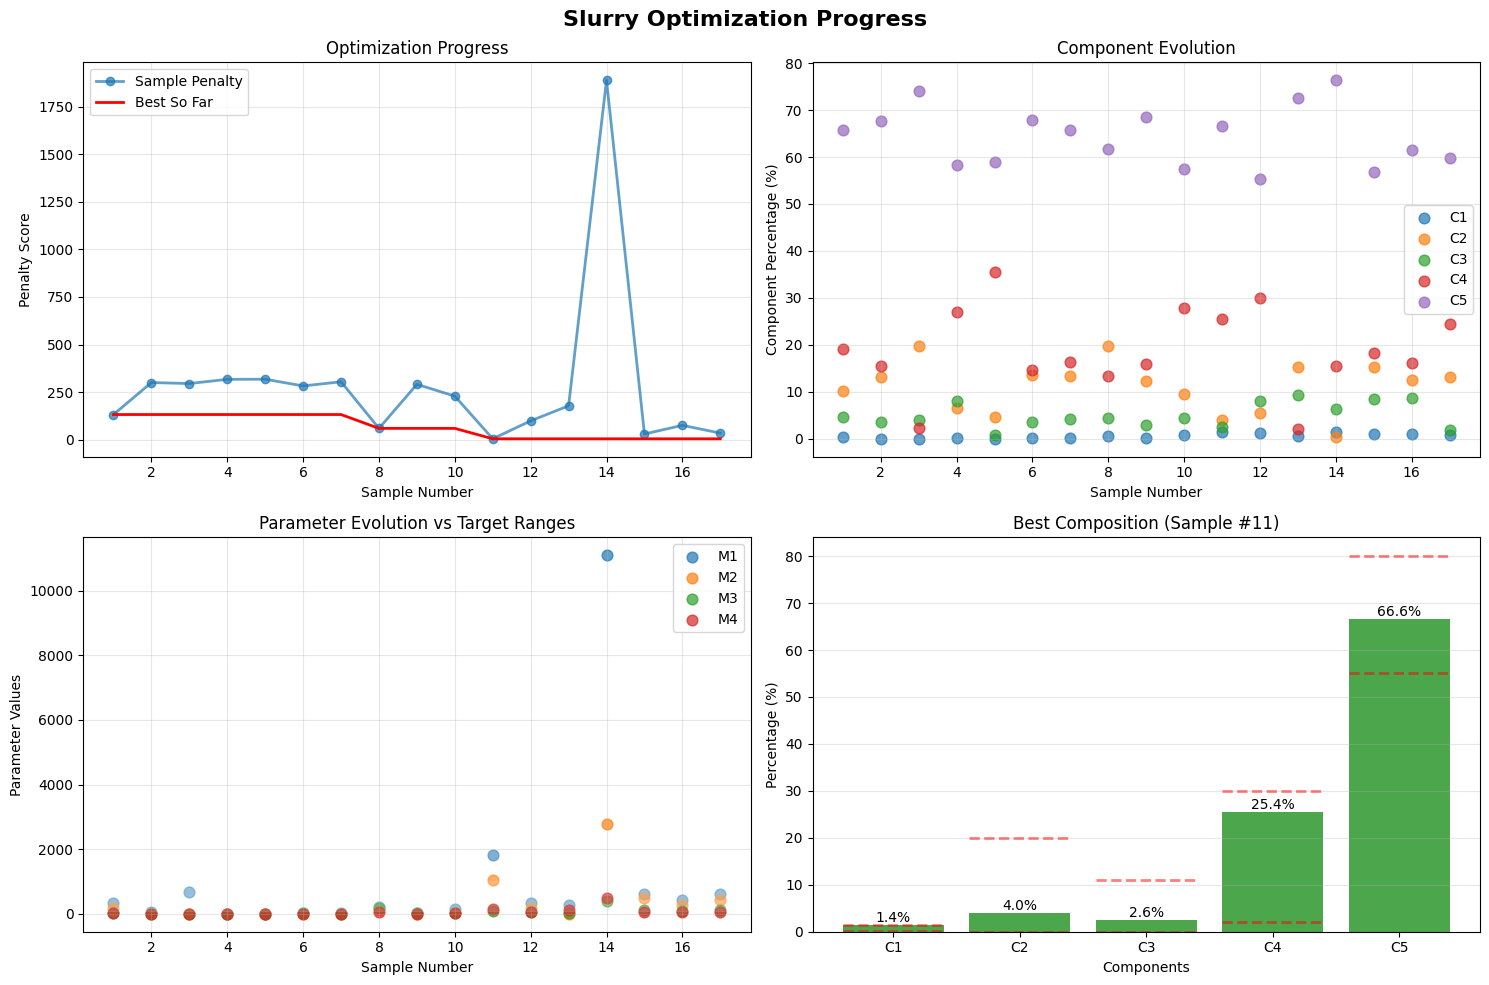


OPTIMIZATION SUMMARY
Total samples tested: 17
Current iteration: 4
Best penalty: 4.0000
Best sample: #11

Best composition:
  C1: 1.42%
  C2: 3.97%
  C3: 2.56%
  C4: 25.45%
  C5: 66.63%

Best measurements:
  M1: 1810.00 [25-10000] ✓
  M2: 1050.00 [100-2000] ✓
  M3: 96.00 [100-800] ✗
  M4: 147.00 [100-1000] ✓

Parameters in optimal range: 3/4

Improvement from initial batch:
  Initial best penalty: 131.6000
  Current best penalty: 4.0000
  Improvement: 127.6000 (97.0%)


In [9]:
if 'all_compositions' not in locals():
    print("❌ No data to visualize yet!")
    print("Please run sections 5-6 first to load some measurements.")
else:
    # Calculate penalties for all data
    all_penalties = calculate_penalty(all_measurements)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Slurry Optimization Progress', fontsize=16, fontweight='bold')
    
    # 1. Penalty Progress
    ax1 = axes[0, 0]
    ax1.plot(range(1, len(all_penalties[0]) + 1), all_penalties[0].cpu().numpy(), 
             'o-', linewidth=2, markersize=6, alpha=0.7, label='Sample Penalty')
    
    # Show best penalty line
    best_penalties = []
    for i in range(len(all_penalties[0])):
        best_penalties.append(all_penalties[0][:i+1].min().item())
    ax1.plot(range(1, len(best_penalties) + 1), best_penalties, 
             'r-', linewidth=2, label='Best So Far')
    
    ax1.set_xlabel('Sample Number')
    ax1.set_ylabel('Penalty Score')
    ax1.set_title('Optimization Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Component Evolution
    ax2 = axes[0, 1]
    comp_data = all_compositions.cpu().numpy()
    for i, comp_name in enumerate(COMPONENT_NAMES):
        ax2.scatter(range(1, len(comp_data) + 1), comp_data[:, i], 
                   alpha=0.7, label=comp_name, s=60)
    ax2.set_xlabel('Sample Number')
    ax2.set_ylabel('Component Percentage (%)')
    ax2.set_title('Component Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Parameter Distribution vs Targets
    ax3 = axes[1, 0]
    meas_data = all_measurements.cpu().numpy()
    
    for i, param_name in enumerate(PARAMETER_NAMES):
        values = meas_data[:, i]
        low, high = OPTIMAL_RANGES[param_name]
        
        # Plot parameter values
        ax3.scatter(range(1, len(values) + 1), values, 
                   alpha=0.7, label=param_name, s=60)
        
        # Plot optimal range as horizontal bands
        color = ax3.get_children()[-1].get_facecolor()
        ax3.axhspan(low, high, alpha=0.1, color=color)
    
    ax3.set_xlabel('Sample Number')
    ax3.set_ylabel('Parameter Values')
    ax3.set_title('Parameter Evolution vs Target Ranges')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Best Composition
    ax4 = axes[1, 1]
    best_idx = all_penalties[0].argmin()
    best_comp = all_compositions[best_idx].cpu().numpy()
    
    x_pos = np.arange(len(COMPONENT_NAMES))
    bars = ax4.bar(x_pos, best_comp, alpha=0.7, color='green')
    
    # Add bounds as horizontal lines
    for i, name in enumerate(COMPONENT_NAMES):
        low, high = COMPONENT_BOUNDS[name]
        ax4.hlines([low, high], i-0.4, i+0.4, colors='red', 
                  linestyles='--', alpha=0.5, linewidth=2)
    
    ax4.set_xlabel('Components')
    ax4.set_ylabel('Percentage (%)')
    ax4.set_title(f'Best Composition (Sample #{best_idx + 1})')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(COMPONENT_NAMES)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, best_comp)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"OPTIMIZATION SUMMARY")
    print(f"{'='*60}")
    print(f"Total samples tested: {len(all_penalties[0])}")
    print(f"Current iteration: {current_iteration}")
    print(f"Best penalty: {all_penalties[0].min().item():.4f}")
    print(f"Best sample: #{best_idx + 1}")
    
    print(f"\nBest composition:")
    for name, val in zip(COMPONENT_NAMES, best_comp):
        print(f"  {name}: {val:.2f}%")
    
    print(f"\nBest measurements:")
    best_meas = all_measurements[best_idx]
    params_in_range = 0
    for i, param in enumerate(PARAMETER_NAMES):
        value = best_meas[i].item()
        low, high = OPTIMAL_RANGES[param]
        in_range = low <= value <= high
        if in_range:
            params_in_range += 1
            status = "✓"
        else:
            status = "✗"
        print(f"  {param}: {value:.2f} [{low}-{high}] {status}")
    
    print(f"\nParameters in optimal range: {params_in_range}/{len(PARAMETER_NAMES)}")
    
    n_initial = 5

    # Improvement analysis
    if len(all_penalties[0]) > n_initial:
        initial_best = all_penalties[0][:n_initial].min().item()
        current_best = all_penalties[0].min().item()
        improvement = initial_best - current_best
        improvement_pct = (improvement / initial_best) * 100 if initial_best > 0 else 0
        print(f"\nImprovement from initial batch:")
        print(f"  Initial best penalty: {initial_best:.4f}")
        print(f"  Current best penalty: {current_best:.4f}")
        print(f"  Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")

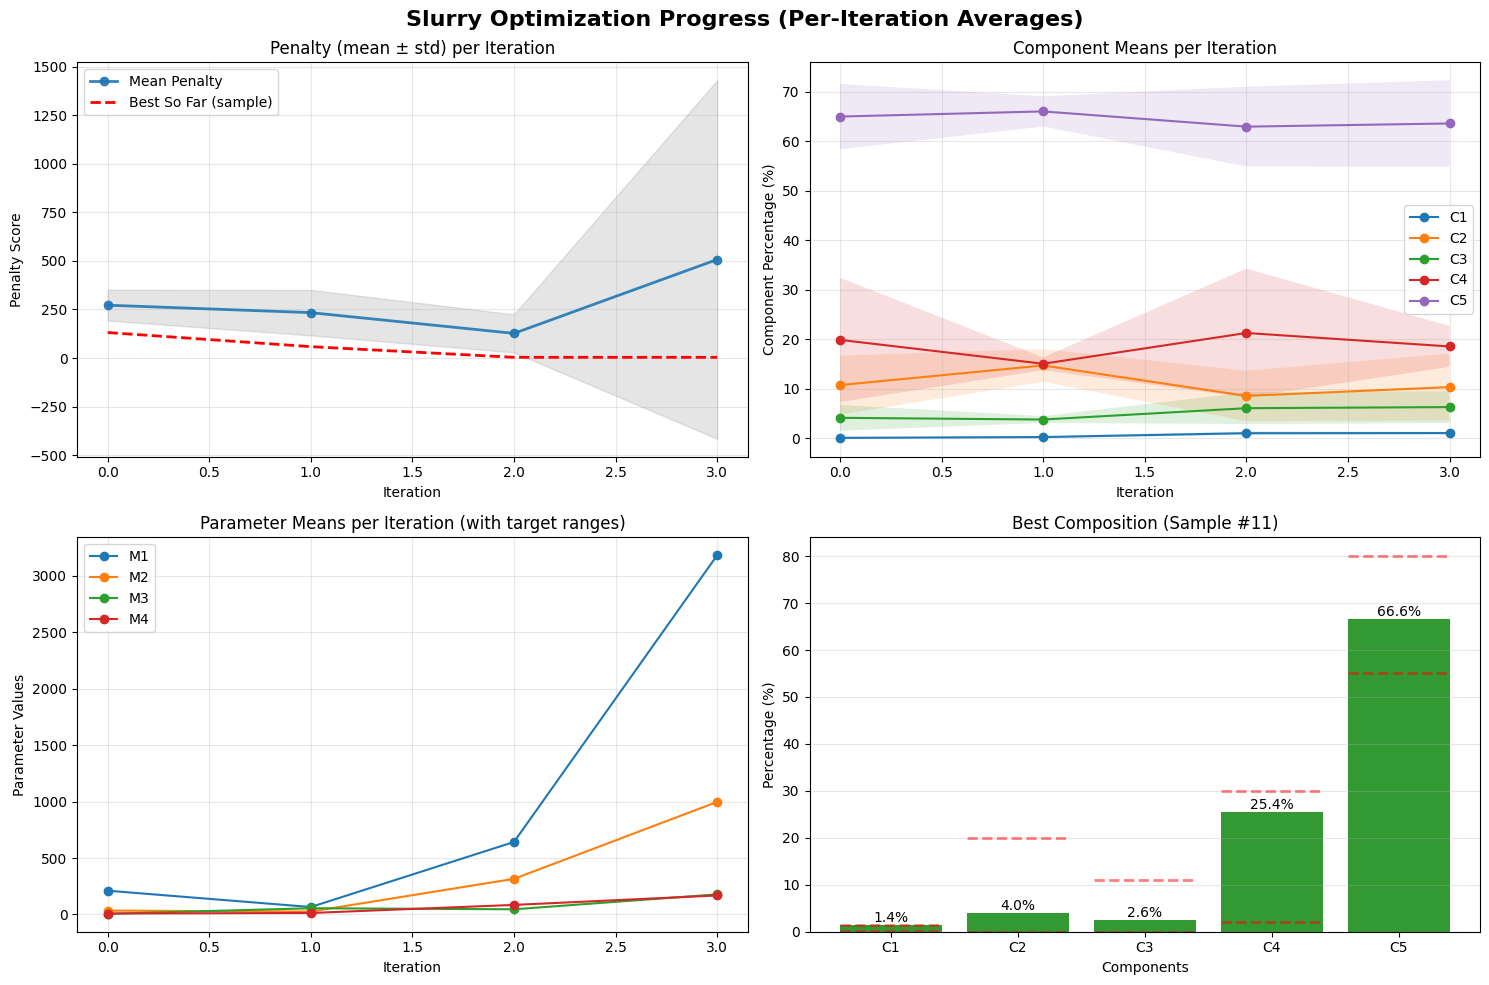


OPTIMIZATION SUMMARY
Total samples tested: 17
Current iteration: 4
Best penalty: 4.0000
Best sample: #11

Best composition:
  C1: 1.42%
  C2: 3.97%
  C3: 2.56%
  C4: 25.45%
  C5: 66.63%

Best measurements:
  M1: 1810.00 [25-10000] ✓
  M2: 1050.00 [100-2000] ✓
  M3: 96.00 [100-800] ✗
  M4: 147.00 [100-1000] ✓

Parameters in optimal range: 3/4

Improvement from initial batch:
  Initial best penalty: 131.6000
  Current best penalty: 4.0000
  Improvement: 127.6000 (97.0%)


In [8]:
if "all_compositions" not in locals():
    print("❌ No data to visualize yet!")
    print("Please run sections 5-6 first to load some measurements.")
else:
    # Read the main CSV and select completed measurements
    if not os.path.exists(MAIN_CSV):
        print(f"❌ Main CSV not found: {MAIN_CSV}")
    else:
        df = pd.read_csv(MAIN_CSV)
        if 'Iteration' not in df.columns:
            print("❌ 'Iteration' column not found in CSV. Please ensure iterations are recorded.")
        else:
            complete_mask = ~df[PARAMETER_NAMES].isna().any(axis=1)
            complete_df = df[complete_mask].copy()
            if len(complete_df) == 0:
                print("❌ No complete measurements in CSV yet. Fill M1-M4 for samples and rerun.")
            else:
                # Compute per-sample penalties and attach to DataFrame
                meas_tensor = torch.tensor(complete_df[PARAMETER_NAMES].values, dtype=dtype, device=device)
                penalties, penalty_vars = calculate_penalty(meas_tensor)
                complete_df = complete_df.reset_index(drop=True)
                complete_df['Penalty'] = penalties.cpu().numpy()

                # Group by iteration and compute mean/std for penalty, components and parameters
                group_cols = ['Iteration']
                agg_means = complete_df.groupby('Iteration').agg({
                    'Penalty': ['mean', 'std'],
                    **{c: ['mean', 'std'] for c in COMPONENT_NAMES},
                    **{p: ['mean', 'std'] for p in PARAMETER_NAMES}
                })
                # Flatten MultiIndex columns
                agg_means.columns = ['_'.join(col).strip() for col in agg_means.columns.values]
                iterations = agg_means.index.to_list()

                # Plotting: penalty mean/std per iteration, component means, parameter means with ranges
                fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                fig.suptitle('Slurry Optimization Progress (Per-Iteration Averages)', fontsize=16, fontweight='bold')

                # 1) Penalty progress (mean ± std)
                ax1 = axes[0, 0]
                penalty_mean = agg_means['Penalty_mean'].values
                penalty_std = agg_means['Penalty_std'].fillna(0).values
                ax1.plot(iterations, penalty_mean, 'o-', linewidth=2, markersize=6, alpha=0.9, label='Mean Penalty')
                ax1.fill_between(iterations, penalty_mean - penalty_std, penalty_mean + penalty_std, color='gray', alpha=0.2)

                # Best-so-far line based on cumulative minimum of per-sample penalties
                cummins = [complete_df[complete_df['Iteration'] <= it]['Penalty'].min() for it in iterations]
                ax1.plot(iterations, cummins, 'r--', linewidth=2, label='Best So Far (sample)')
                ax1.set_xlabel('Iteration')
                ax1.set_ylabel('Penalty Score')
                ax1.set_title('Penalty (mean ± std) per Iteration')
                ax1.legend()
                ax1.grid(True, alpha=0.3)

                # 2) Component evolution: mean per iteration
                ax2 = axes[0, 1]
                for cname in COMPONENT_NAMES:
                    mean_col = f"{cname}_mean"
                    std_col = f"{cname}_std"
                    if mean_col in agg_means.columns:
                        ax2.plot(iterations, agg_means[mean_col].values, marker='o', label=cname)
                        # shaded std
                        y = agg_means[mean_col].values
                        ystd = agg_means[std_col].fillna(0).values if std_col in agg_means.columns else np.zeros_like(y)
                        ax2.fill_between(iterations, y - ystd, y + ystd, alpha=0.15)
                ax2.set_xlabel('Iteration')
                ax2.set_ylabel('Component Percentage (%)')
                ax2.set_title('Component Means per Iteration')
                ax2.legend()
                ax2.grid(True, alpha=0.3)

                # 3) Parameter means per iteration with optimal ranges
                ax3 = axes[1, 0]
                for pname in PARAMETER_NAMES:
                    mean_col = f"{pname}_mean"
                    std_col = f"{pname}_std"
                    if mean_col in agg_means.columns:
                        y = agg_means[mean_col].values
                        ystd = agg_means[std_col].fillna(0).values if std_col in agg_means.columns else np.zeros_like(y)
                        ax3.plot(iterations, y, marker='o', label=pname)
                        # ax3.fill_between(iterations, y - ystd, y + ystd, alpha=0.15)
                        # low, high = OPTIMAL_RANGES[pname]
                        # ax3.axhspan(low, high, alpha=0.08)
                ax3.set_xlabel('Iteration')
                ax3.set_ylabel('Parameter Values')
                ax3.set_title('Parameter Means per Iteration (with target ranges)')
                ax3.legend()
                ax3.grid(True, alpha=0.3)

                # 4) Best composition (based on lowest per-sample penalty across all data)
                ax4 = axes[1, 1]
                best_row = complete_df.loc[complete_df['Penalty'].idxmin()]
                best_comp = best_row[COMPONENT_NAMES].values.astype(float)
                x_pos = np.arange(len(COMPONENT_NAMES))
                bars = ax4.bar(x_pos, best_comp, alpha=0.8, color='green')
                for i, name in enumerate(COMPONENT_NAMES):
                    low, high = COMPONENT_BOUNDS[name]
                    ax4.hlines([low, high], i - 0.4, i + 0.4, colors='red', linestyles='--', alpha=0.5, linewidth=2)
                ax4.set_xlabel('Components')
                ax4.set_ylabel('Percentage (%)')
                ax4.set_title(f"Best Composition (Sample #{int(best_row['Sample_ID'])})")
                ax4.set_xticks(x_pos)
                ax4.set_xticklabels(COMPONENT_NAMES)
                ax4.grid(True, alpha=0.3, axis='y')
                for i, (bar, val) in enumerate(zip(bars, best_comp)):
                    height = bar.get_height()
                    ax4.text(bar.get_x() + bar.get_width() / 2.0, height, f"{val:.1f}%", ha='center', va='bottom')

                plt.tight_layout()
                plt.show()

                # Print summary statistics (keep same printouts as before)
                total_samples = len(complete_df)
                detected_current_iter = int(df['Iteration'].max()) if 'Iteration' in df.columns else None
                print(f"\n{'='*60}")
                print(f"OPTIMIZATION SUMMARY")
                print(f"{'='*60}")
                print(f"Total samples tested: {total_samples}")
                print(f"Current iteration: {detected_current_iter}")
                print(f"Best penalty: {complete_df['Penalty'].min():.4f}")
                print(f"Best sample: #{int(best_row['Sample_ID'])}")

                print(f"\nBest composition:")
                for name, val in zip(COMPONENT_NAMES, best_comp):
                    print(f"  {name}: {val:.2f}%")

                print(f"\nBest measurements:")
                for p in PARAMETER_NAMES:
                    value = best_row[p]
                    low, high = OPTIMAL_RANGES[p]
                    in_range = low <= value <= high
                    status = '✓' if in_range else '✗'
                    print(f"  {p}: {value:.2f} [{low}-{high}] {status}")

                params_in_range = sum([1 for p in PARAMETER_NAMES if OPTIMAL_RANGES[p][0] <= best_row[p] <= OPTIMAL_RANGES[p][1]])
                print(f"\nParameters in optimal range: {params_in_range}/{len(PARAMETER_NAMES)}")

                # Improvement analysis using per-sample penalties (preserve previous logic)
                n_initial = globals().get('n_initial', 5)
                if total_samples > n_initial:
                    initial_best = complete_df['Penalty'].iloc[:n_initial].min()
                    current_best = complete_df['Penalty'].min()
                    improvement = initial_best - current_best
                    improvement_pct = (improvement / initial_best) * 100 if initial_best > 0 else 0
                    print(f"\nImprovement from initial batch:")
                    print(f"  Initial best penalty: {initial_best:.4f}")
                    print(f"  Current best penalty: {current_best:.4f}")
                    print(f"  Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")

## 9. Workflow Helper: Check Status

Run this cell to see current status and what to do next.

In [ ]:
print(f"{'='*60}")
print(f"WORKFLOW STATUS")
print(f"{'='*60}\n")

# Check what data exists
if 'current_iteration' not in locals():
    print("❌ Status: NOT STARTED")
    print("\nYou need to:")
    print("  1. Run Section 5 to generate initial batch")
else:
    print(f"✓ Current iteration: {current_iteration}")
    
    # Check if measurements are loaded
    if 'train_X' in locals() and 'train_Y' in locals():
        print(f"✓ Training data: {len(train_X)} samples")
        print(f"✓ Best penalty so far: {train_Y.min().item():.4f}")
        
        # Check main CSV file
        if os.path.exists(MAIN_CSV):
            df = pd.read_csv(MAIN_CSV)
            total_samples = len(df)
            complete_samples = (~df[PARAMETER_NAMES].isna().any(axis=1)).sum()
            incomplete_samples = total_samples - complete_samples
            
            print(f"\nMain CSV file: {MAIN_CSV}")
            print(f"  Total samples: {total_samples}")
            print(f"  Complete: {complete_samples}")
            print(f"  Awaiting measurements: {incomplete_samples}")
            
            if incomplete_samples > 0:
                incomplete_ids = df[df[PARAMETER_NAMES].isna().any(axis=1)]['Sample_ID'].tolist()
                print(f"  Samples needing measurements: {incomplete_ids}")
            
            # Show iterations
            if 'Iteration' in df.columns:
                iteration_counts = df.groupby('Iteration').size()
                print(f"\nBatches in file:")
                for iter_num, count in iteration_counts.items():
                    iter_complete = (~df[df['Iteration'] == iter_num][PARAMETER_NAMES].isna().any(axis=1)).sum()
                    status = "✓" if iter_complete == count else f"⏳ ({iter_complete}/{count})"
                    print(f"  Iteration {iter_num}: {count} samples {status}")
        
        # Determine next step
        print(f"\n{'='*60}")
        print(f"NEXT STEP:")
        print(f"{'='*60}")
        
        if 'batch_start_idx' in locals() and 'batch_end_idx' in locals():
            # Check if current batch has measurements
            df = pd.read_csv(MAIN_CSV)
            current_batch = df[(df['Sample_ID'] >= batch_start_idx) & (df['Sample_ID'] <= batch_end_idx)]
            has_measurements = ~current_batch[PARAMETER_NAMES].isna().any().any()
            
            if has_measurements:
                print(f"→ Run Section 6 to load measurements for samples #{batch_start_idx}-#{batch_end_idx}")
                print(f"→ Then run Section 7 to generate next batch")
            else:
                print(f"→ Fill in measurements for samples #{batch_start_idx}-#{batch_end_idx} in {MAIN_CSV}")
                print(f"→ Then run Section 6 to load the results")
        else:
            print(f"→ Run Section 7 to generate next batch")
    else:
        print(f"❌ No training data loaded yet")
        print(f"\nYou need to:")
        if 'batch_start_idx' in locals():
            print(f"  1. Fill in measurements for samples #{batch_start_idx}-#{batch_end_idx} in {MAIN_CSV}")
        else:
            print(f"  1. Fill in measurements in {MAIN_CSV}")
        print(f"  2. Run Section 6 to load the measurements")

print(f"\n{'='*60}")
print(f"WORKFLOW CYCLE:")
print(f"{'='*60}")
print(f"Section 5: Generate initial batch → Adds to CSV")
print(f"  ↓ (Measure in lab)")
print(f"Section 6: Load measurements → Update model")
print(f"  ↓")
print(f"Section 7: Generate next batch → Adds to SAME CSV")
print(f"  ↓ (Measure in lab)")
print(f"Section 6: Load measurements → Repeat...")
print(f"\nSection 8: Visualize progress (anytime)")
print(f"\n💡 All batches accumulate in ONE file: {MAIN_CSV}")

WORKFLOW STATUS

✓ Current iteration: 2
✓ Training data: 13 samples
✓ Best penalty so far: 4.0000

Main CSV file: optimization_data\all_batches.csv
  Total samples: 13
  Complete: 13
  Awaiting measurements: 0

Batches in file:
  Iteration 0: 5 samples ✓
  Iteration 1: 4 samples ✓
  Iteration 2: 4 samples ✓

NEXT STEP:
→ Run Section 7 to generate next batch

WORKFLOW CYCLE:
Section 5: Generate initial batch → Adds to CSV
  ↓ (Measure in lab)
Section 6: Load measurements → Update model
  ↓
Section 7: Generate next batch → Adds to SAME CSV
  ↓ (Measure in lab)
Section 6: Load measurements → Repeat...

Section 8: Visualize progress (anytime)

💡 All batches accumulate in ONE file: optimization_data\all_batches.csv


In [ ]:
combined_train_X_and_next_X = torch.cat([train_X, next_X])

In [ ]:
print("CMC in water\n")
for comp in combined_train_X_and_next_X:
    # print(comp.cpu().numpy())
    print((comp[0]/comp[3]).item()*100)

CMC in water

2.358490566037736
0.0
1.3452914798206277
0.5177514792899409
0.05614823133071309
1.3577732518669383
1.2277470841006755
4.166666666666667
1.257861635220126
3.2420749279538903
5.579567779960707
4.366666666666666
32.5
1.581085459880319
4.902435455631327
9.60675235351373
4.373175387722361


In [18]:
sample_id = 14
if 'all_sample_ids' in globals() and 'all_measurements' in globals():
    try:
        idx = all_sample_ids.index(sample_id)
    except ValueError:
        print(f"Sample_ID {sample_id} not present in `all_sample_ids` (in-memory).")
    else:
        meas = all_measurements[idx:idx+1]   # keep batch dimension
        penalty, penalty_var = calculate_penalty(meas)
        print(
            f"Sample_ID {sample_id} penalty (from in-memory data) = {penalty[0].item():.6f}, {penalty_var[0]}"
        )
else:
    print("In-memory variables `all_sample_ids`/`all_measurements` not available. Use Option A.")

(25 ,10000) - 1100
(100 ,2000) - 790
(100 ,800) - 0
(100 ,1000) - 0
Sample_ID 14 penalty (from in-memory data) = 1890.000000, 0.030000160000000005
